# Enjoy DiffusionCLIP: Text-guided Image Manipulation Using Diffusion Models

<a href="https://colab.research.google.com/drive/1cvb5xZY7NU6tgkpuYwiLIAOr9KPYJkv_" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
This will install required packages and take a few minutes. Pydrive enable to avoid Google Drive download limit.


In [ ]:
#@title Setup
import os
diffusionclip_dir = os.path.join("/content", "DiffusionCLIP")
from getpass import getpass
print('Make your GitHub Personal access token and insert it below.')
github_token = getpass('GitHub Personal Token')
! git clone https://{github_token}@github.com/submission10095/DiffusionCLIP_temp.git $diffusionclip_dir

os.chdir(f'./DiffusionCLIP')
os.makedirs("checkpoint", exist_ok=True)
os.makedirs("precomputed", exist_ok=True)
os.makedirs("pretrained", exist_ok=True)
os.makedirs("runs", exist_ok=True)

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

from utils.colab_utils import GoogleDrive_Dowonloader
download_with_pydrive = True #@param {type:"boolean"}
dl = GoogleDrive_Dowonloader(download_with_pydrive)


from diffusionclip import DiffusionCLIP
from main import dict2namespace
import argparse
import yaml
from PIL import Image
import warnings
warnings.filterwarnings(action='ignore')

device = 'cuda'

%load_ext autoreload
%autoreload 2

# Manipulation of Images in Trained Domain & to Unseen Domain
You can edit one image into the CLIP-guided domain. 
- Use the image path of samples in `./imgs` or use your uploaded image. 
- We provide a wide range of `edit_type`, but you can also use your finetuned models by uploadint them in `./checkpoint`.
- You can control the degree of change by controling `degree_of_change` from 0.0 (no change) to 1.0 (full change).
- `n_inv_step` can be chosen in `[0, t_0]` where `t_0` is set depending on the finetuned models automatically  e.g. 4 ~ 200
- `n_test_step` can be chosen in `[0, n_inv_step]` e.g. 6 or 40.
  - We found that the manipulation quality is better when n_***_step does not divide t_0. So we usally use 301, 401, 500 or 601 for t_0.
- Image is inverted to the latent once for each image at the first time. From the next time, the image is generated from the latent without the inversion.
- You can use your finetuned models by uploading them in `./checkpoint`.
- The models are downloaded one time.


checkpoint/pixar_t601.pth exists.
return step t_0: 601
None is loaded.
checkpoint/pixar_t601.pth is loaded.
Latent exists.
Sampling type: DDIM with eta 0.0,  Steps: 40/601
Uniform skip type


Generative process 0: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]

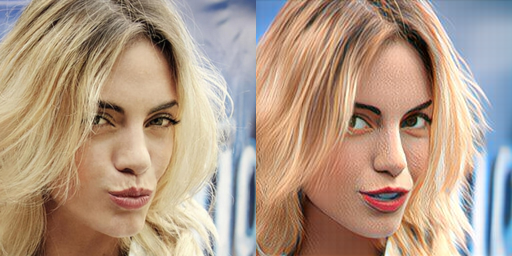

In [6]:
#@title Human face manipulation

img_path = 'imgs/celeb1.png'  #@param {type:"string"}
edit_type = 'Pixar' #@param ['Pixar', 'Neanderthal','Sketch', 'Painting by Gogh','Tanned',  'With makeup']
degree_of_change = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
human_gdrive_ids = {'Pixar':                   ["1IoT7kZhtaoKf1uvhYhvyqzyG2MOJsqLe", "pixar_t601.pth"],
                    'Neanderthal':             ["1Uo0VI5kbATrQtckhEBKUPyRFNOcgwwne", "neanderthal_t601.pth"],
                    'Sketch':                  ["11m93QBToohZUhdyIsOnNK7XAextj2-fW", "sketch_t601.pth"],
                    'Painting by Gogh':        ["1UDL2auElNsVwU8BGUI7SFG5JrYebc1zw", "gogh_t601.pth"],
                    'Tanned':                  ["15Twto21spGLwiby7_yGO_xquFXtfJIAo", "tanned_t301.pth"],
                    'With makeup':             ["1RusgHSK-XAX15k2T68c2C_f01e3TBrLf", "with_makeuap_t401.pth"],
                    'Without makeup':          ["157pTJBkXPoziGQdjy3SwdyeSpAjQiGRp", "without_makeup_t301.pth"],
                    }

gid = human_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', human_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)
result_dir = os.path.join(exp_dir, model_path.split('/')[-1])
os.makedirs(result_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40 #@param {type: "integer"}
n_test_step = 6 #@param {type: "integer"}
args_dic = {
    'config': 'celeba.yml', 
    't_0': t_0, 
    'n_inv_step': n_inv_step, 
    'n_test_step': n_test_step,
    'sample_type': 'ddim', 
    'eta': 0.0,
    'bs_test': 1, 
    'model_path': model_path, 
    'img_path': img_path, 
    'deterministic_inv': 1, 
    'hybrid_noise': 0, 
    'n_iter': 1,  
    'image_folder': result_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(result_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(result_dir, f'3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}.png'))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid

Finished
return step t_0: 500


Downloading: "https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/bedroom.ckpt" to /root/.cache/torch/hub/checkpoints/bedroom.ckpt


  0%|          | 0.00/434M [00:00<?, ?B/s]

None is loaded.
checkpoint/princess_t500.pth is loaded.


Inversion process :  98%|█████████▊| 39/40 [00:19<00:00,  1.98it/s]


Sampling type: DDIM with eta 0.0,  Steps: 40/500
Uniform skip type


Generative process 0: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]

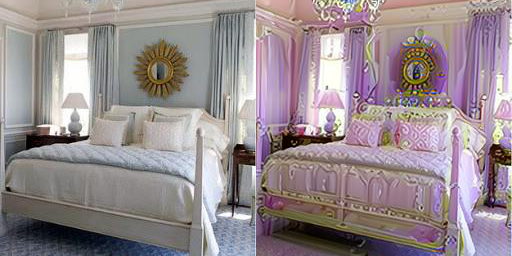

In [8]:
#@title Bedroom manipulation

img_path = 'imgs/bedroom1.png'  #@param {type:"string"}
edit_type = 'Princess bedroom' #@param['Princess bedroom', 'Wooden bedroom','Blue tone bedroom', 'Green tone bedroom', 'Watercolor art']
degree_of_change = 1.0 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
bedroom_gdrive_ids = {'Princess bedroom':   ["1gBbyWCDLfBQpoPuNkpc9Ioqu4wJW8o3b", "princess_t500.pth"],
                      'Wooden bedroom':     ["1ATF3o7RCSrgi0icwi9HaaZxf2C-DwwTp", "wooden_t500.pth"],
                      'Blue tone bedroom':  ["1qAC4ORH5sk3YfXDQ-3QUiXDxMsmJB0g8", "blue_t500.pth"],
                      'Green tone bedroom': ["1ClX_LUgpG5igDq0rWTsD7xIzyzGRvge_", "green_t601.pth"],
                      'Watercolor art':     ["1ewVadFKi9YLQaaPjqN7UsH6UuEeGX4mf", "watercolor_t601.pth"],
                     }


gid = bedroom_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', bedroom_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)
result_dir = os.path.join(exp_dir, model_path.split('/')[-1])
os.makedirs(result_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40 #@param {type: "integer"}
n_test_step = 6 #@param {type: "integer"}
args_dic = {
    'config': 'bedroom.yml', 
    't_0': t_0, 
    'n_inv_step': n_inv_step, 
    'n_test_step': n_test_step,
    'sample_type': 'ddim', 
    'eta': 0.0,
    'bs_test': 1, 
    'model_path': model_path, 
    'img_path': img_path, 
    'deterministic_inv': 1, 
    'hybrid_noise': 0, 
    'n_iter': 1,  
    'image_folder': result_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(result_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(result_dir, f'3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}.png'))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid

Finished
return step t_0: 500


Downloading: "https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/church_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/church_outdoor.ckpt


  0%|          | 0.00/434M [00:00<?, ?B/s]

None is loaded.
checkpoint/ancient_tower_t500.pth is loaded.


Inversion process :  98%|█████████▊| 39/40 [00:19<00:00,  1.97it/s]


Sampling type: DDIM with eta 0.0,  Steps: 40/500
Uniform skip type


Generative process 0: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]

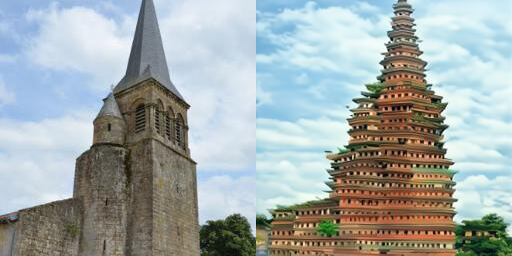

In [9]:
#@title Church manipulation

img_path = 'imgs/church1.png'  #@param {type:"string"}
edit_type = 'Asian ancient tower' #@param['Golden church', 'Red brick church', 'Snow covered church', 'Wooden house', 'Asian ancient tower', 'Department store']
degree_of_change = 1.0 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
church_gdrive_ids = {'Golden church':       ["16T7N8LHPyM_-3TSCSggg683PjfJQaR15", "golden_t401.pth"],
                     'Red brick church':    ["1_FWVnjR2nsW0SACZDuU-HT53hn5C1TsR", "brick_t301.pth"],
                     'Snow covered church': ["1-k_W15TY0TjZQnONXHah2x1jonVd8ePZ", "snow_t500.pth"],
                     'Wooden house':        ["1R0l-GQdXaOQJfcrb81vv9sgD9z8mBSPK", "wooden_t500.pth"],
                     'Asian ancient tower': ["12DC1lL6moUy1teKe7gxqL2NQhhmU44eB", "ancient_tower_t500.pth"],
                     'Department store':    ["1XcL3IM85dG5nk9-3CiXAsdIZaguSZyMw", "department_t500.pth"],
                     }

gid = church_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', church_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
print(f'return step t_0: {t_0}')
exp_dir = f"runs/MANI_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)
result_dir = os.path.join(exp_dir, model_path.split('/')[-1])
os.makedirs(result_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40 #@param {type: "integer"}
n_test_step = 6 #@param {type: "integer"}
args_dic = {
    'config': 'church.yml', 
    't_0': t_0, 
    'n_inv_step': n_inv_step, 
    'n_test_step': n_test_step,
    'sample_type': 'ddim', 
    'eta': 0.0,
    'bs_test': 1, 
    'model_path': model_path, 
    'img_path': img_path, 
    'deterministic_inv': 1, 
    'hybrid_noise': 0, 
    'n_iter': 1,  
    'image_folder': result_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.edit_one_image()

# Result
print()
n_result = 1
img = Image.open(os.path.join(result_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
for i in range(n_result):
  img = Image.open(os.path.join(result_dir, f'3_gen_t{t_0}_it0_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}.png'))
  img = img.resize((int(img.width), int(img.height)))
  grid.paste(img, (int(img.height * (i+1)), 0))
grid

# Generation of Images in Unseen Domain from Strokes
- Use the image path of samples in `./imgs` or your image by uploading it.
- If the distribution of the noisy image from the source unseen domain and the trained domains are not overlaped enough, the translation may fail. In other words, the source image need to be similar in terms of structure and shape.
- `n_inv_step` can be chosen in `[0, t_0]` where `t_0` is set depending on the finetuned models automatically  e.g. 40.
- `n_test_step` can be chosen in `[0, n_inv_step]` e.g. 6 or 40.
- `n_iter_forward` determine the iteration of the foward and generative process to tranlate the source image in the unseen domain to the image in the trained domain. It can be normally chosen between 1 and 12. This process is stochastic, so it will produce differenct result at each run.
- By increasing `n_result`, you can see multiple results from one input, but this require more run time.
- To make your own image strokes, you can use any painter application e.g. https://pixlr.com/kr/x/ .

checkpoint/pixar_t601.pth exists.
Original diffusion Model loaded.
Sampling type: DDIM with eta 0.0
Uniform skip type


Inversion process :  98%|█████████▊| 39/40 [00:17<00:00,  2.18it/s]


Original diffusion Model loaded.
Sampling type: DDIM with eta 0.0,  Steps: 40/601
Uniform skip type


Generative process 38: 100%|██████████| 40/40 [00:18<00:00,  2.15it/s]

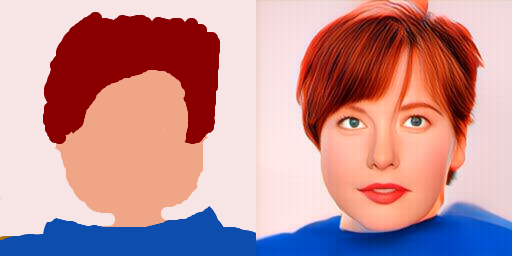

In [ ]:
#@title Stroke ➝ Unseen domain
img_path = 'imgs/celeb1.png'  #@param {type:"string"}
edit_type = 'Pixar' #@param ['Pixar', 'Neanderthal','Sketch', 'Painting by Gogh','Tanned',  'With makeup']
degree_of_change = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
human_gdrive_ids = {'Pixar':                   ["1IoT7kZhtaoKf1uvhYhvyqzyG2MOJsqLe", "pixar_t601.pth"],
                    'Neanderthal':             ["1Uo0VI5kbATrQtckhEBKUPyRFNOcgwwne", "neanderthal_t601.pth"],
                    'Sketch':                  ["11m93QBToohZUhdyIsOnNK7XAextj2-fW", "sketch_t601.pth"],
                    'Painting by Gogh':        ["1UDL2auElNsVwU8BGUI7SFG5JrYebc1zw", "gogh_t601.pth"],
                    'Tanned':                  ["15Twto21spGLwiby7_yGO_xquFXtfJIAo", "tanned_t301.pth"],
                    'With makeup':             ["1RusgHSK-XAX15k2T68c2C_f01e3TBrLf", "with_makeuap_t401.pth"],
                    'Without makeup':          ["157pTJBkXPoziGQdjy3SwdyeSpAjQiGRp", "without_makeup_t301.pth"],
                    }

gid = human_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', human_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
exp_dir = f"runs/S2U_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)
result_dir = os.path.join(exp_dir, model_path.split('/')[-1])
os.makedirs(result_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40 #@param {type: "integer"}
n_test_step = 6 #@param {type: "integer"}
n_iter_forward =  5 #@param {type: "integer"}
n_result =  1#@param {type: "integer"}
args_dic = {
    'config': 'celeba.yml', 
    't_0': t_0, 
    'n_inv_step': n_inv_step, 
    'n_test_step': n_test_step,
    'sample_type': 'ddim', 
    'eta': 0.0,
    'bs_test': n_result, 
    'model_path': model_path, 
    'img_path': img_path, 
    'deterministic_inv': 1, 
    'hybrid_noise': 0, 
    'n_iter': n_iter_forward,  
    'image_folder': result_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.unseen2unseen()


# Result
print()
img = Image.open(os.path.join(result_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
img = Image.open(os.path.join(result_dir, f'4_gen_t{t_0}_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}.png'))
img = img.resize((int(img.width), int(img.height)))
grid.paste(img, (int(img.width//n_result), 0))
grid

# Image Translation from Unseen Domain into Another Unseen Domain
- Use the image path of samples in `./imgs` or your image by uploading it.
- If the distribution of the noisy image from the source unseen domain and the trained domains are not overlaped enough, the translation may fail. In other words, the source image need to be similar in terms of structure and shape.
- `n_inv_step` can be chosen in `[0, t_0]` where `t_0` is set depending on the finetuned models automatically  e.g. 40.
- `n_test_step` can be chosen in `[0, n_inv_step]` e.g. 6 or 40.
- `n_iter_forward` determine the iteration of the foward and generative process to tranlate the source image in the unseen domain to the image in the trained domain. It can be normally chosen between 1 and 12. This process is stochastic, so it will produce differenct result at each run.
- By increasing `n_result`, you can see multiple results from one input, but this require more run time.



checkpoint/pixar_t601.pth exists.
Original diffusion Model loaded.
Sampling type: DDIM with eta 0.0
Uniform skip type


Inversion process :  98%|█████████▊| 39/40 [00:18<00:00,  2.16it/s]


Original diffusion Model loaded.
Sampling type: DDIM with eta 0.0,  Steps: 40/601
Uniform skip type


Generative process 38: 100%|██████████| 40/40 [00:18<00:00,  2.17it/s]

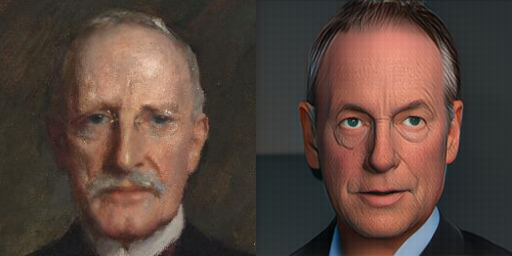

In [ ]:
#@title Unseen domain ➝ Unseen domain
img_path = 'imgs/celeb1.png'  #@param {type:"string"}
edit_type = 'Pixar' #@param ['Pixar', 'Neanderthal','Sketch', 'Painting by Gogh','Tanned',  'With makeup']
degree_of_change = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Finetuned model download
human_gdrive_ids = {'Pixar':                   ["1IoT7kZhtaoKf1uvhYhvyqzyG2MOJsqLe", "pixar_t601.pth"],
                    'Neanderthal':             ["1Uo0VI5kbATrQtckhEBKUPyRFNOcgwwne", "neanderthal_t601.pth"],
                    'Sketch':                  ["11m93QBToohZUhdyIsOnNK7XAextj2-fW", "sketch_t601.pth"],
                    'Painting by Gogh':        ["1UDL2auElNsVwU8BGUI7SFG5JrYebc1zw", "gogh_t601.pth"],
                    'Tanned':                  ["15Twto21spGLwiby7_yGO_xquFXtfJIAo", "tanned_t301.pth"],
                    'With makeup':             ["1RusgHSK-XAX15k2T68c2C_f01e3TBrLf", "with_makeuap_t401.pth"],
                    'Without makeup':          ["157pTJBkXPoziGQdjy3SwdyeSpAjQiGRp", "without_makeup_t301.pth"],
                    }

gid = human_gdrive_ids[edit_type][0]
model_path = os.path.join('checkpoint', human_gdrive_ids[edit_type][1])
dl.ensure_file_exists(gid, model_path)

t_0 = int(model_path.split('_t')[-1].replace('.pth',''))
exp_dir = f"runs/U2U_{img_path.split('/')[-1]}"
os.makedirs(exp_dir, exist_ok=True)
result_dir = os.path.join(exp_dir, model_path.split('/')[-1])
os.makedirs(result_dir, exist_ok=True)

# Test arg, config
n_inv_step = 40 #@param {type: "integer"}
n_test_step = 6 #@param {type: "integer"}
n_iter_forward =   1#@param {type: "integer"}
n_result =  1#@param {type: "integer"}
args_dic = {
    'config': 'celeba.yml', 
    't_0': t_0, 
    'n_inv_step': n_inv_step, 
    'n_test_step': n_test_step,
    'sample_type': 'ddim', 
    'eta': 0.0,
    'bs_test': n_result, 
    'model_path': model_path, 
    'img_path': img_path, 
    'deterministic_inv': 1, 
    'hybrid_noise': 0, 
    'n_iter': n_iter_forward,  
    'image_folder': result_dir,
    'model_ratio': degree_of_change,
    'edit_attr': None, 'src_txts': None, 'trg_txts': None,
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
config.device = device

# Edit
runner = DiffusionCLIP(args, config)
runner.unseen2unseen()


# Result
print()
img = Image.open(os.path.join(result_dir, '0_orig.png'))
img = img.resize((int(img.width), int(img.height)))
grid = Image.new("RGB", (img.width*(n_result+1), img.height))
grid.paste(img, (0, 0))
img = Image.open(os.path.join(result_dir, f'4_gen_t{t_0}_ninv{n_inv_step}_ngen{n_test_step}_mrat{degree_of_change}.png'))
img = img.resize((int(img.width), int(img.height)))
grid.paste(img, (int(img.width//n_result), 0))
grid